In [18]:
import os
import torch
from io import BytesIO
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils
from torchvision import transforms, datasets
from torchvision.transforms import functional as trans_fn
from PIL import Image
import numpy as np
from utils import Logger
from tensorboardX import SummaryWriter
from matplotlib import pyplot as plt
import socket

# Variables

In [2]:
IMAGE_SIZE = 200

# UDP stuff
# UDP_IP = "127.0.0.1"
# UDP_PORT = 11999
# sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)

# Output Dir
OUT_DIR = "/Users/alex/Projects/programming/latent-space-explorer/bin/data/latent"

# Classes & Helpers

In [19]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = IMAGE_SIZE * IMAGE_SIZE * 3
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU  (0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = torch.randn(size, 100)
    return n
    
def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 3, IMAGE_SIZE, IMAGE_SIZE)
    
logger = Logger(model_name='VGAN', data_name='FLICKR_MOUNTAIN')

# Load Model

In [4]:
generator = GeneratorNet()
generator.load_state_dict(torch.load("./models/flickr-mountain-generator-200.pt"))
generator.eval()

GeneratorNet(
  (hidden0): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=120000, bias=True)
    (1): Tanh()
  )
)

# Interpolator

In [215]:
class Interpolator():
    def __init__(self, generator):
        self.generator = generator
        self.writer = SummaryWriter()
        self.minX = noise(1)
        self.maxX = noise(1)
        self.minY = noise(1)
        self.maxY = noise(1)
        self.minZ = noise(1)
        self.maxZ = noise(1)
        
    def interpolate_vector(self, x, y, z):
        x_vector = self.interpolate_axis(self.minX, self.maxX, x)
        y_vector = self.interpolate_axis(self.minY, self.maxY, y)
        z_vector = self.interpolate_axis(self.minZ, self.maxZ, z)
        
        return (x_vector + y_vector + z_vector) / 3.0
    
    def generate_pil_image(self, x, y, z):
        vec = self.interpolate_vector(x, y, z)
        
        image_data = vectors_to_images(self.generator(vec))
        image_data = image_data.data
        
        horizontal_grid = vutils.make_grid(image_data, normalize=True, scale_each=True)
        
        image = np.moveaxis(horizontal_grid.numpy(), 0, -1)
        pil_image = Image.fromarray(np.uint8(image*255))
        
        return pil_image
    
    def generate_x_axis_pil_image(self, pos):
        vec = self.interpolate_axis(self.minX, self.maxX, pos)
        
        image_data = vectors_to_images(self.generator(vec))
        image_data = image_data.data
        
        horizontal_grid = vutils.make_grid(image_data, normalize=True, scale_each=True)
        
        image = np.moveaxis(horizontal_grid.numpy(), 0, -1)
        pil_image = Image.fromarray(np.uint8(image*255))
        
        return pil_image
    
    def generate_x_axis_range(self, steps):
        inter_vectors = [] #array of tensors

        for i in range(steps):
            new_vector = self.interpolate_axis(self.minX, self.maxX, i / (steps - 1))
            inter_vectors.append(new_vector)
            
        inter_tensor = torch.stack(inter_vectors, 0)
        inter_data = self.generator(inter_tensor)
        inter_images = vectors_to_images(inter_data)
        inter_images = inter_images.data
        logger.log_images(inter_images, 1, 1, 1, 1);
        
    def interpolate_axis(self, start, end, perc):
        inter = start + ((end - start) * perc)
        return inter
    
    def setMinX(self, minX):
        self.minX = minX
    
    def setMaxX(self, maxX):
        self.maxX = maxX
        
    def setMinY(self, minY):
        self.minY = minY
    
    def setMaxY(self, maxY):
        self.maxY = maxY
    
    def setMinZ(self, minZ):
        self.minZ = minZ
    
    def setMaxZ(self, maxZ):
        self.maxZ = maxZ
        
interpolator = Interpolator(generator)

# Sample Latent Space

torch.Size([21, 3, 200, 200])


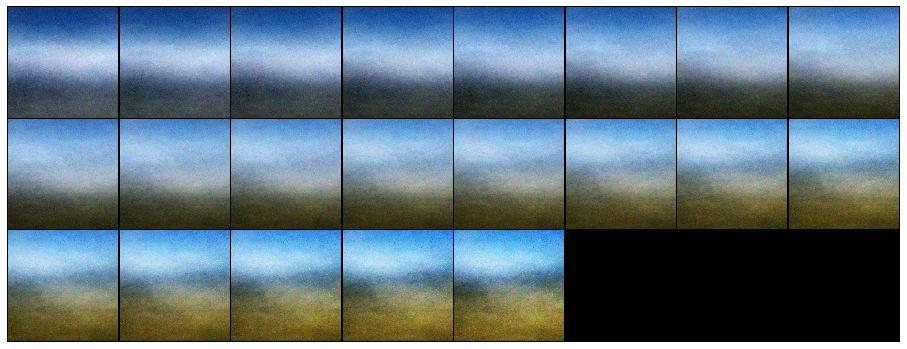

In [216]:
interpolator.setMinX(everest)
interpolator.setMaxX(monet)
interpolator.generate_x_axis_range(21)

# Generate 3D Latent Space

In [218]:
divisions = 21

def generate_3d_latent_space(num_div):
    for x in range(num_div):
        for y in range (num_div):
            for z in range(num_div):
                x_pos = x / (num_div - 1)
                y_pos = y / (num_div - 1)
                z_pos = z / (num_div - 1)

                image = interpolator.generate_pil_image(x_pos, 1, z_pos)

                image.save(OUT_DIR + "/" + str(x_pos) + "-" + str(y_pos) + "-" + str(z_pos) + ".jpg")

def generate_x_axis_latent_space(num_div):
    for x in range(num_div):
        x_pos = x / (num_div - 1)
        image = interpolator.generate_x_axis_pil_image(x_pos)
        image.save(OUT_DIR + "/monet-everest/" + str(x_pos) + ".jpg")
                
                
generate_x_axis_latent_space(divisions)

In [144]:
everest = new_sky

In [145]:
monet

himalayas

everest

twilight

tensor([[-0.6981, -0.6256,  0.4414, -1.3739, -0.4692, -1.1881,  1.2764, -0.3317,
          0.8009,  0.2008, -0.6859, -0.4955,  1.2172,  0.6755,  0.3293,  0.2224,
         -2.2693,  0.7397, -0.1277,  0.3186,  1.1931, -0.3278,  0.2313,  0.3364,
          1.4430, -0.3935, -0.3415, -0.2178, -0.6586,  0.4881, -1.8050,  0.2319,
          1.1329, -1.1997,  0.6190,  0.4497,  0.2897,  1.3220,  1.1768,  1.6495,
         -0.7229,  0.9223,  0.0343,  0.4186,  1.6122,  1.3299, -0.8184, -0.5834,
          0.1240, -0.3697, -1.8364, -2.0358,  0.0981, -1.8025, -0.5929, -0.8098,
         -0.7112, -0.1262,  1.1621,  1.3253,  0.9131, -0.1740, -0.6635,  0.9107,
          0.6138,  1.0468,  0.1739, -0.2391,  0.3215, -0.5834, -1.0444,  1.5956,
          0.5593, -0.3729, -0.9429,  0.4524, -0.9460, -0.9995, -1.4104,  2.1585,
         -0.4348,  0.7184,  0.0098, -0.1752,  1.7271, -1.1008, -0.7067, -0.4095,
          0.8335, -1.3473,  0.6241,  1.1387, -0.3545, -0.2671,  0.8869, -2.4586,
          0.4768,  0.1747, -